In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import ntpath
import sys
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

### Declare models

In [2]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_state=128):
        super(DenoisingAutoencoder, self).__init__()
        self.hidden_state = hidden_state
        self.encoder = nn.Sequential(
            nn.Linear(n_features, hidden_state * 2),
            nn.Tanh(),
            nn.Linear(hidden_state * 2, hidden_state),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_state, hidden_state * 2),
            nn.Tanh(),
            nn.Linear(hidden_state * 2, n_features)
        )
        
                
    def forward(self, x):
        representation = self.encoder(x)
        return representation, self.decoder(representation)

In [3]:
class LSTMClassifier(nn.Module):

    def __init__(self, n_features, n_classes, hidden_state=128):
        super(LSTMClassifier, self).__init__()
        self.hidden_state = hidden_state
        self.lstm = nn.LSTM(n_features, hidden_state)
        self.predictor = nn.Linear(hidden_state, n_classes)

    def _get_hidden_state(self, batch_size):
        return torch.randn(1, batch_size, self.hidden_state), torch.randn(1, batch_size, self.hidden_state)

    def forward(self, sequence, lengths):
        batch_size = sequence.size()[0]
        packed_sequence = pack_padded_sequence(sequence, lengths, batch_first=True)
        
        hidden_init = self._get_hidden_state(batch_size)
        out_seq, (hidden_states, _) = self.lstm(packed_sequence, hidden_init)
        log_prediction = F.log_softmax(self.predictor(hidden_states[-1]), dim=-1)

        return log_prediction

    def predict_proba(self, sequence, lengths):
        return torch.exp(self.forward(sequence, lengths))
    
    def predict(self, sequence, lengths):
        return self.predict_proba(sequence, lengths).max(dim=-1)[1]

### Load noisifier

In [5]:
from NoiseLoader import NoiseLoader
from add_noise import add_noise_to_audio, process_directory
from util import load_audio_sec, write_audio_file
import librosa

In [6]:
noise_dirs = ['../bg_noise/FRESOUND_BEEPS_gsm/train', '../bg_noise/freesound_background_gsm']

In [7]:
noise_loader = NoiseLoader(noise_dirs, sample_rate=None)

#### Check that noisification works

In [8]:
audio, sr = load_audio_sec('data/corpus/VCTK-Corpus/wav48/p226/p226_010.wav', sr=None)
audio_noised = add_noise_to_audio(audio, noise_loader, nr=0.3)

In [9]:
IPython.display.Audio(audio, rate=48000)

In [10]:
IPython.display.Audio(audio_noised, rate=48000)

In [11]:
write_audio_file('sample.wav', audio_noised, None)

#### Save files with random noise for further extraction of kaldi features

In [ ]:
process_directory('data/corpus/VCTK-Corpus/wav48/', 'data/noised_corpus/', noise_loader, sr=None, nr=0.3)

### Extract kaldi features

In [6]:
from kaldi.feat.mfcc import Mfcc, MfccOptions
from kaldi.matrix import SubVector, SubMatrix
from kaldi.util.options import ParseOptions
from kaldi.util.table import SequentialWaveReader, SequentialMatrixReader, MatrixWriter

In [7]:
NUM_PEOPLE = 0

np.random.seed(42)

train_wav_paths = []
train_wav_paths_noised = []
train_classes = []
test_wav_paths = []
test_wav_paths_noised = []
test_classes = []

wav_dir = 'data/corpus/VCTK-Corpus/wav48/'
for num, person in enumerate(os.listdir(wav_dir)):
    NUM_PEOPLE += 1
    person_dir = os.path.join('data/corpus/VCTK-Corpus/wav48/', person)
    wav_names = list(map(lambda wav_name: os.path.join(person_dir, wav_name), os.listdir(person_dir)))
    wav_names = list(filter(lambda filename: filename.endswith('.wav'), wav_names))
    train_person_speech, test_person_speech = train_test_split(wav_names, test_size=0.2)
    
    train_wav_paths.extend(train_person_speech)
    train_wav_paths_noised.extend(list(map(lambda wav_path: f'data/noised_corpus/{ntpath.basename(wav_path)}', 
                                           train_person_speech)))
    train_classes.extend([num] * len(train_person_speech))
    
    test_wav_paths.extend(test_person_speech)
    test_wav_paths_noised.extend(list(map(lambda wav_path: f'data/noised_corpus/{ntpath.basename(wav_path)}', 
                                          test_person_speech)))
    test_classes.extend([num] * len(test_person_speech))

print(f'Number of people : {NUM_PEOPLE}')
print(f'train : {len(train_wav_paths)}')
print(f'test  : {len(test_wav_paths)}')

Number of people : 109
train : 35346
test  : 8896


In [8]:
train_wav_paths[:5], train_wav_paths_noised[:5]

(['data/corpus/VCTK-Corpus/wav48/p302/p302_150.wav',
  'data/corpus/VCTK-Corpus/wav48/p302/p302_292.wav',
  'data/corpus/VCTK-Corpus/wav48/p302/p302_172.wav',
  'data/corpus/VCTK-Corpus/wav48/p302/p302_176.wav',
  'data/corpus/VCTK-Corpus/wav48/p302/p302_312.wav'],
 ['data/noised_corpus/p302_150.wav',
  'data/noised_corpus/p302_292.wav',
  'data/noised_corpus/p302_172.wav',
  'data/noised_corpus/p302_176.wav',
  'data/noised_corpus/p302_312.wav'])

In [8]:
def write_descriptor(wav_paths, desc_path):
    with open(desc_path, 'w') as output:
        for wav_path in wav_paths:
            output.write('{} {}\n'.format(wav_path, wav_path))

In [9]:
train_desc_path = 'train_desc.scp'
train_desc_noised_path = 'train_desc_noised.scp'
test_desc_path = 'test_desc.scp'
test_desc_noised_path = 'test_desc_noised.scp'

In [17]:
write_descriptor(train_wav_paths, train_desc_path)
write_descriptor(train_wav_paths_noised, train_desc_noised_path)
write_descriptor(test_wav_paths, test_desc_path)
write_descriptor(test_wav_paths_noised, test_desc_noised_path)

In [9]:
def compute_kaldi_features(desc_path, output_path, samp_freq):
    print(f'Started processing {desc_path}')
    rspec, wspec = f'scp:{desc_path}', f'ark:{output_path}'
    
    mfcc_opts = MfccOptions()
    mfcc_opts.frame_opts.samp_freq = samp_freq

    mfcc = Mfcc(mfcc_opts)
    sf = mfcc_opts.frame_opts.samp_freq
    
    with SequentialWaveReader(rspec) as reader, MatrixWriter(wspec) as writer:      
        for key, wav in tqdm(reader):
            assert(wav.samp_freq >= sf)
            assert(wav.samp_freq % sf == 0)
    
            s = wav.data()
            s = s[:,::int(wav.samp_freq / sf)]
            m = SubVector(np.mean(s, axis=0))

            f = mfcc.compute_features(m, sf, 1.0)
            f = SubMatrix(scale(f))
            writer[key] = f

    print(f'Extracted features were written to {output_path}') 

In [10]:
samp_freq = 16000
train_kaldi_path = 'train_kaldi.ark'
train_kaldi_noised_path = 'train_kaldi_noised.ark'
test_kaldi_path = 'test_kaldi.ark'
test_kaldi_noised_path = 'test_kaldi_noised.ark'

In [20]:
compute_kaldi_features(train_desc_path, train_kaldi_path, samp_freq)
compute_kaldi_features(test_desc_path, test_kaldi_path, samp_freq)
compute_kaldi_features(train_desc_noised_path, train_kaldi_noised_path, samp_freq)
compute_kaldi_features(test_desc_noised_path, test_kaldi_noised_path, samp_freq)

5it [00:00, 44.72it/s]

Started processing train_desc.scp


35346it [10:05, 58.37it/s]
5it [00:00, 42.98it/s]

Extracted features were written to train_kaldi.ark
Started processing test_desc.scp


8896it [02:41, 55.07it/s]
5it [00:00, 45.62it/s]

Extracted features were written to test_kaldi.ark
Started processing train_desc_noised.scp


35346it [10:13, 57.66it/s]
5it [00:00, 45.81it/s]

Extracted features were written to train_kaldi_noised.ark
Started processing test_desc_noised.scp


8896it [02:36, 56.82it/s]

Extracted features were written to test_kaldi_noised.ark


In [11]:
def read_features(kaldi_path, limit=None):
    print(f'Started reading from {kaldi_path}')
    features = []
    rspec = f'ark:{kaldi_path}'
    with SequentialMatrixReader(rspec) as reader:
        for i, (key, mat) in tqdm(enumerate(reader)):
            if limit is not None and limit <= i:
                break
            features.append(torch.tensor(mat, dtype=torch.float))
            
    print(f'Loaded features from {kaldi_path}')
    return features

In [12]:
train_features = read_features(train_kaldi_path)
# train_noised_features = read_features(train_kaldi_noised_path)
test_features = read_features(test_kaldi_path)
# test_noised_features = read_features(test_kaldi_noised_path)

7it [00:00, 66.84it/s]

Started reading from train_kaldi.ark


35346it [06:21, 92.56it/s] 
8it [00:00, 77.38it/s]

Loaded features from train_kaldi.ark
Started reading from test_kaldi.ark


8896it [01:36, 92.56it/s] 

Loaded features from test_kaldi.ark


In [13]:
min(train_features, key=lambda s: s.size()[0]).size()

torch.Size([83, 13])

In [14]:
max(train_features, key=lambda s: s.size()[0]).size()

torch.Size([1926, 13])

### Train model without autoencoder

In [15]:
N_FEATURES = train_features[0].size()[1]
EPOCHS = 100
BATCH_SIZE = 512
HIDDEN_STATE = 32
TRAIN_SIZE = len(train_features)
TEST_SIZE = len(test_features)

In [55]:
model = LSTMClassifier(N_FEATURES, NUM_PEOPLE, HIDDEN_STATE)
optimizer = optim.Adam(model.parameters(), lr=0.02)
loss_function = nn.NLLLoss()

In [56]:
def pack_batch(features, labels, indices):
    indices = sorted(indices, key=lambda ind: features[ind].size()[0], reverse=True)
    lengths = list(map(lambda ind: features[ind].size()[0], indices))
    seq = list(map(lambda ind: features[ind], indices))
    inputs = pad_sequence(seq, batch_first=True)
    targets = torch.LongTensor(list(map(lambda ind: labels[ind], indices)))
    return inputs, lengths, targets

In [57]:
train_losses = []
test_losses = []
test_acc = []

train_ids = np.arange(TRAIN_SIZE)
test_ids = np.arange(TEST_SIZE)

for epoch in range(EPOCHS):
    print(f'Started epoch {epoch + 1}')
    np.random.shuffle(train_ids)
    
    model.train()
    loss_train = 0
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):
        model.zero_grad()
        
        sequence, lengths, targets = pack_batch(train_features,
                                                train_classes, 
                                                train_ids[i : min(i + BATCH_SIZE, TRAIN_SIZE)])
        
        predictions = model(sequence, lengths)
        loss = loss_function(predictions, targets)
        loss.backward()
        # Avoid gradient explode
        nn.utils.clip_grad_norm_(model.parameters(), 6.)
        optimizer.step()
        loss_train += loss.item()
        
    train_losses.append(loss_train * BATCH_SIZE / TRAIN_SIZE)
    print(f'Average loss: {loss_train * BATCH_SIZE / TRAIN_SIZE}')
    
    model.eval()
    loss_test = 0
    correct_test = 0
    with torch.no_grad():
        for i in range(0, TEST_SIZE, BATCH_SIZE):
            sequence, lengths, targets = pack_batch(test_features,
                                                    test_classes, 
                                                    test_ids[i : min(i + BATCH_SIZE, TEST_SIZE)])
            log_predictions = model(sequence, lengths)
            predictions = torch.exp(log_predictions).max(dim=-1)[1]
            correct_test += (predictions == targets).sum().item()
            loss_test += loss_function(log_predictions, targets)
    
    test_losses.append(loss_test * BATCH_SIZE / TEST_SIZE)
    test_acc.append(correct_test / TEST_SIZE)
    print(f'Average test loss: {loss_test * BATCH_SIZE / TEST_SIZE}')
    print(f'Accuracy: {correct_test / TEST_SIZE}')

Started epoch 1
Average loss: 4.067595542795905
Average test loss: 3.872361898422241
Accuracy: 0.12410071942446044
Started epoch 2
Average loss: 3.166055185782824
Average test loss: 2.9076955318450928
Accuracy: 0.29856115107913667
Started epoch 3
Average loss: 2.50749659221241
Average test loss: 2.406134843826294
Accuracy: 0.40152877697841727
Started epoch 4
Average loss: 2.084084722281163
Average test loss: 2.088575839996338
Accuracy: 0.47425809352517984
Started epoch 5
Average loss: 1.8110430494118632
Average test loss: 1.8175709247589111
Accuracy: 0.5359712230215827
Started epoch 6
Average loss: 1.6259900401041003
Average test loss: 1.6612368822097778
Accuracy: 0.5696942446043165
Started epoch 7
Average loss: 1.4983918446808646
Average test loss: 1.581531047821045
Accuracy: 0.5850944244604317
Started epoch 8
Average loss: 1.3827182811002527
Average test loss: 1.4776064157485962
Accuracy: 0.6115107913669064
Started epoch 9
Average loss: 1.3034698170325363
Average test loss: 1.4464855

Average test loss: 0.6336811780929565
Accuracy: 0.8221672661870504
Started epoch 72
Average loss: 0.36165002388911804
Average test loss: 0.6156347393989563
Accuracy: 0.8304856115107914
Started epoch 73
Average loss: 0.37766425295123784
Average test loss: 0.7142559289932251
Accuracy: 0.8031699640287769
Started epoch 74
Average loss: 0.3655797729250437
Average test loss: 0.5878611207008362
Accuracy: 0.8348696043165468
Started epoch 75
Average loss: 0.3529721449316307
Average test loss: 0.6134431958198547
Accuracy: 0.8328462230215827
Started epoch 76
Average loss: 0.34432431408095315
Average test loss: 0.5766953229904175
Accuracy: 0.8443120503597122
Started epoch 77
Average loss: 0.3192129323459984
Average test loss: 0.591635525226593
Accuracy: 0.8399280575539568
Started epoch 78
Average loss: 0.36256373162680516
Average test loss: 0.5709370374679565
Accuracy: 0.8409397482014388
Started epoch 79
Average loss: 0.31559210881807537
Average test loss: 0.5834137797355652
Accuracy: 0.8397032374

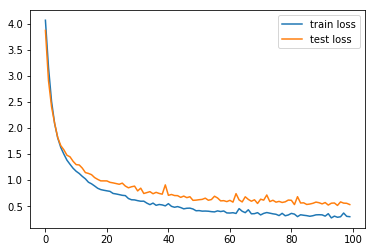

In [58]:
plt.plot(np.arange(EPOCHS), train_losses, label='train loss')
plt.plot(np.arange(EPOCHS), test_losses, label='test loss')
plt.legend()

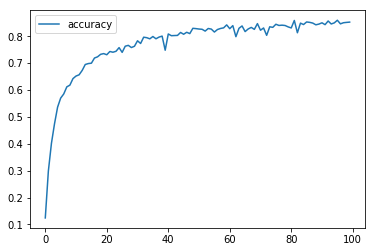

In [59]:
plt.plot(np.arange(EPOCHS), test_acc, label='accuracy')
plt.legend()

In [60]:
EPOCHS = 100

train_losses = []
test_losses = []
test_acc = []

train_ids = np.arange(TRAIN_SIZE)
test_ids = np.arange(TEST_SIZE)

for epoch in range(EPOCHS):
    print(f'Started epoch {epoch + 1}')
    np.random.shuffle(train_ids)
    
    model.train()
    loss_train = 0
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):
        model.zero_grad()
        
        sequence, lengths, targets = pack_batch(train_features,
                                                train_classes, 
                                                train_ids[i : min(i + BATCH_SIZE, TRAIN_SIZE)])
        
        predictions = model(sequence, lengths)
        loss = loss_function(predictions, targets)
        loss.backward()
        # Avoid gradient explode
        nn.utils.clip_grad_norm_(model.parameters(), 6.)
        optimizer.step()
        loss_train += loss.item()
        
    train_losses.append(loss_train * BATCH_SIZE / TRAIN_SIZE)
    print(f'Average loss: {loss_train * BATCH_SIZE / TRAIN_SIZE}')
    
    model.eval()
    loss_test = 0
    correct_test = 0
    with torch.no_grad():
        for i in range(0, TEST_SIZE, BATCH_SIZE):
            sequence, lengths, targets = pack_batch(test_features,
                                                    test_classes, 
                                                    test_ids[i : min(i + BATCH_SIZE, TEST_SIZE)])
            log_predictions = model(sequence, lengths)
            predictions = torch.exp(log_predictions).max(dim=-1)[1]
            correct_test += (predictions == targets).sum().item()
            loss_test += loss_function(log_predictions, targets)
    
    test_losses.append(loss_test * BATCH_SIZE / TEST_SIZE)
    test_acc.append(correct_test / TEST_SIZE)
    print(f'Average test loss: {loss_test * BATCH_SIZE / TEST_SIZE}')
    print(f'Accuracy: {correct_test / TEST_SIZE}')

Started epoch 1
Average loss: 0.31213113779070045
Average test loss: 0.5021806955337524
Accuracy: 0.8617356115107914
Started epoch 2
Average loss: 0.2814298152842641
Average test loss: 0.4927998185157776
Accuracy: 0.8655575539568345
Started epoch 3
Average loss: 0.2561602445960834
Average test loss: 0.5362634658813477
Accuracy: 0.8503821942446043
Started epoch 4
Average loss: 0.2760211711679136
Average test loss: 0.6285359859466553
Accuracy: 0.8300359712230215
Started epoch 5
Average loss: 0.3139932596075753
Average test loss: 0.5242934823036194
Accuracy: 0.8572392086330936
Started epoch 6
Average loss: 0.27352567923222115
Average test loss: 0.6848723888397217
Accuracy: 0.8192446043165468
Started epoch 7
Average loss: 0.32602866941266506
Average test loss: 0.6248506307601929
Accuracy: 0.8314973021582733
Started epoch 8
Average loss: 0.3179556469368771
Average test loss: 0.5362050533294678
Accuracy: 0.8594874100719424
Started epoch 9
Average loss: 0.27427160159130287
Average test loss: 

Average loss: 0.2305274537724914
Average test loss: 0.4677276015281677
Accuracy: 0.8747751798561151
Started epoch 72
Average loss: 0.216701336616046
Average test loss: 0.5042330622673035
Accuracy: 0.8689298561151079
Started epoch 73
Average loss: 0.21825365539129443
Average test loss: 0.4912697672843933
Accuracy: 0.8712904676258992
Started epoch 74
Average loss: 0.2706957331255769
Average test loss: 0.5534124970436096
Accuracy: 0.8500449640287769
Started epoch 75
Average loss: 0.26327204894501494
Average test loss: 0.5258888602256775
Accuracy: 0.8566771582733813
Started epoch 76
Average loss: 0.25274344412814925
Average test loss: 0.5162673592567444
Accuracy: 0.864658273381295
Started epoch 77
Average loss: 0.22038019759096625
Average test loss: 0.5025384426116943
Accuracy: 0.867693345323741
Started epoch 78
Average loss: 0.20097229637638564
Average test loss: 0.5215311646461487
Accuracy: 0.8656699640287769
Started epoch 79
Average loss: 0.2436415573497421
Average test loss: 0.50702106

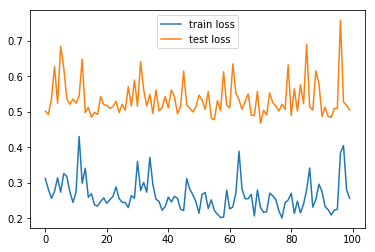

In [61]:
plt.plot(np.arange(EPOCHS), train_losses, label='train loss')
plt.plot(np.arange(EPOCHS), test_losses, label='test loss')
plt.legend()

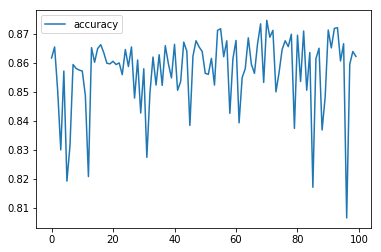

In [62]:
plt.plot(np.arange(EPOCHS), test_acc, label='accuracy')
plt.legend()

### Save the model

In [132]:
torch.save(model.state_dict(), 'kaldi_only_200.pth')

### Train autoencoder

#### Load noised and clean data

Since every audio has about 300-400 frames, we don't need all the data and can limit it to several thousand samples

In [108]:
NUM_NOISED_TRAIN_SEQ = 10000
NUM_NOISED_TEST_SEQ = 1000

In [ ]:
train_noised_features = read_features(train_kaldi_noised_path, limit=NUM_NOISED_TRAIN_SEQ + NUM_NOISED_TEST_SEQ)

In [110]:
test_noised_features = train_noised_features[NUM_NOISED_TRAIN_SEQ:]
train_noised_features = train_noised_features[:NUM_NOISED_TRAIN_SEQ]

In [111]:
train_clean_features = train_features[:NUM_NOISED_TRAIN_SEQ]
test_clean_features = train_features[NUM_NOISED_TRAIN_SEQ : NUM_NOISED_TRAIN_SEQ + NUM_NOISED_TEST_SEQ]

In [112]:
train_noised_features = torch.cat(train_noised_features, dim=0)
test_noised_features = torch.cat(test_noised_features, dim=0)
train_clean_features = torch.cat(train_clean_features, dim=0)
test_clean_features = torch.cat(test_clean_features, dim=0)

In [113]:
train_noised_features.size(), train_clean_features.size(), test_noised_features.size(), test_clean_features.size()

(torch.Size([3576688, 13]),
 torch.Size([3576688, 13]),
 torch.Size([371265, 13]),
 torch.Size([371265, 13]))

#### Train autoencoder

In [18]:
N_FEATURES = train_features[0].size()[1]
EPOCHS = 50
BATCH_SIZE = 1024
HIDDEN_STATE = 16

In [ ]:
TRAIN_SIZE = len(train_noised_features)
TEST_SIZE = len(test_noised_features)

In [19]:
autoencoder = DenoisingAutoencoder(N_FEATURES, HIDDEN_STATE)
autoencoder.load_state_dict(torch.load('autoencoder.pth'))
autoencoder.eval()

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=13, bias=True)
  )
)

In [130]:
autoencoder = DenoisingAutoencoder(N_FEATURES, HIDDEN_STATE)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
loss_function = nn.MSELoss()

In [131]:
train_features[0].size(), test_features[0]train_losses = []
test_losses = []

train_ids = np.arange(TRAIN_SIZE)
test_ids = np.arange(TEST_SIZE)

for epoch in range(EPOCHS):
    print(f'Started epoch {epoch + 1}')
    np.random.shuffle(train_ids)
    
    autoencoder.train()
    loss_train = 0
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):
        autoencoder.zero_grad()
        
        noised = train_noised_features[i : min(i + BATCH_SIZE, TRAIN_SIZE)]
        clean  = train_clean_features[i : min(i + BATCH_SIZE, TRAIN_SIZE)]
        
        _, denoised = autoencoder(noised)
        loss = loss_function(denoised, clean)
        loss.backward()
        
        optimizer.step()
        loss_train += loss.item()
        
    train_losses.append(loss_train * BATCH_SIZE / TRAIN_SIZE)
    print(f'Average loss: {loss_train * BATCH_SIZE / TRAIN_SIZE}')
    
    autoencoder.eval()
    loss_test = 0
    with torch.no_grad():
        for i in range(0, TEST_SIZE, BATCH_SIZE):
            
            noised = test_noised_features[i : min(i + BATCH_SIZE, TEST_SIZE)]
            clean  = test_clean_features[i : min(i + BATCH_SIZE, TEST_SIZE)]

            _, denoised = autoencoder(noised)
            loss_test += loss_function(denoised, clean)
    
    test_losses.append(loss_test * BATCH_SIZE / TEST_SIZE)
    test_acc.append(correct_test / TEST_SIZE)
    print(f'Average test loss: {loss_test * BATCH_SIZE / TEST_SIZE}')

Started epoch 1
Average loss: 0.48568019007393737
Average test loss: 0.566289484500885
Started epoch 2
Average loss: 0.47198233275487467
Average test loss: 0.5645396113395691
Started epoch 3
Average loss: 0.4702079731080944
Average test loss: 0.5623348355293274
Started epoch 4
Average loss: 0.4694204831037708
Average test loss: 0.5606509447097778
Started epoch 5
Average loss: 0.46883916286390126
Average test loss: 0.5601486563682556
Started epoch 6
Average loss: 0.46846660308504107
Average test loss: 0.5598280429840088
Started epoch 7
Average loss: 0.46820253979943627
Average test loss: 0.5594525337219238
Started epoch 8
Average loss: 0.467894859417377
Average test loss: 0.559010922908783
Started epoch 9
Average loss: 0.46746586644729443
Average test loss: 0.5590372681617737
Started epoch 10
Average loss: 0.46721366082108606
Average test loss: 0.5583301186561584
Started epoch 11
Average loss: 0.46704919496832165
Average test loss: 0.557584285736084
Started epoch 12
Average loss: 0.4668

In [133]:
train_noised_features[:3], autoencoder(train_noised_features[:3])[1], train_clean_features[:3]

(tensor([[-0.6907, -0.7115, -0.8651,  0.6944,  0.3142, -0.1749,  0.3019,
          -0.0844,  0.2971,  0.3684,  0.7409,  1.4016,  1.0316],
         [-0.4129, -0.6118, -0.5216,  0.0776, -0.2267, -1.1624,  0.9007,
           0.2778,  0.3216, -1.4555, -0.0771,  1.3020,  0.4046],
         [-0.4015, -0.2224, -0.5807,  0.2383, -0.9910, -1.0924,  0.5196,
          -0.7728, -1.1204, -0.8870,  0.1900,  1.2975,  1.1363]]),
 tensor([[-0.3282, -0.4876, -0.0500,  0.2027,  0.1703,  0.1369, -0.0958,
           0.2517,  0.3842,  0.3183,  0.3549,  0.4355,  0.4455],
         [-0.6192, -0.3801,  0.1093, -0.1267,  0.1591,  0.0673,  0.0556,
           0.3471,  0.2861, -0.1141,  0.1438,  0.3079,  0.3483],
         [-0.2214, -0.4741, -0.4545,  0.0287, -0.6574, -0.2560, -0.0633,
          -0.2547, -0.1283, -0.1239,  0.0258,  0.7957,  0.5837]]),
 tensor([[-0.3916, -0.6051,  0.5487, -0.0253, -0.0658,  0.5321,  0.7794,
           0.5350,  0.3980,  0.9948,  0.3268, -0.0237,  0.7260],
         [-1.3134, -0.7551,  0

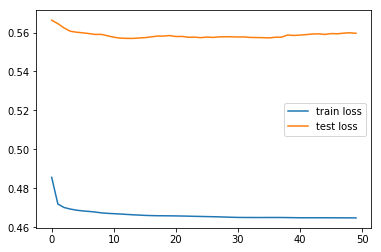

In [134]:
# Loss is shitty, probably, because I've added too much noise
plt.plot(np.arange(EPOCHS), train_losses, label='train loss')
plt.plot(np.arange(EPOCHS), test_losses, label='test loss')
plt.legend()

In [135]:
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

## Train model with autoencoder features

In [20]:
N_FEATURES = train_features[0].size()[1]
EPOCHS = 100
BATCH_SIZE = 512
HIDDEN_STATE = 32
TRAIN_SIZE = len(train_features)
TEST_SIZE = len(test_features)

In [21]:
model = LSTMClassifier(N_FEATURES + autoencoder.hidden_state, NUM_PEOPLE, HIDDEN_STATE)
optimizer = optim.Adam(model.parameters(), lr=0.02)
loss_function = nn.NLLLoss()

In [29]:
def pack_batch_autoencoder(features, labels, indices):
    indices = sorted(indices, key=lambda ind: features[ind].size()[0], reverse=True)
    lengths = list(map(lambda ind: features[ind].size()[0], indices))
    with torch.no_grad():
        seq = list(map(lambda ind: torch.cat([features[ind], autoencoder(features[ind])[0]], dim=-1), indices))
    inputs = pad_sequence(seq, batch_first=True)
    targets = torch.LongTensor(list(map(lambda ind: labels[ind], indices)))
    return inputs, lengths, targets

In [30]:
train_losses = []
test_losses = []
test_acc = []

train_ids = np.arange(TRAIN_SIZE)
test_ids = np.arange(TEST_SIZE)

for epoch in range(EPOCHS):
    print(f'Started epoch {epoch + 1}')
    np.random.shuffle(train_ids)
    
    model.train()
    loss_train = 0
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):
        model.zero_grad()
        
        sequence, lengths, targets = pack_batch_autoencoder(train_features, 
                                                            train_classes, 
                                                            train_ids[i : min(i + BATCH_SIZE, TRAIN_SIZE)])
        predictions = model(sequence, lengths)
        loss = loss_function(predictions, targets)
        loss.backward()
        # Avoid gradient explode
        nn.utils.clip_grad_norm_(model.parameters(), 6.)
        optimizer.step()
        loss_train += loss.item()
        
    train_losses.append(loss_train * BATCH_SIZE / TRAIN_SIZE)
    print(f'Average loss: {loss_train * BATCH_SIZE / TRAIN_SIZE}')
    
    model.eval()
    loss_test = 0
    correct_test = 0
    with torch.no_grad():
        for i in range(0, TEST_SIZE, BATCH_SIZE):
            sequence, lengths, targets = pack_batch_autoencoder(test_features, 
                                                                test_classes, 
                                                                test_ids[i : min(i + BATCH_SIZE, TEST_SIZE)])
            log_predictions = model(sequence, lengths)
            predictions = torch.exp(log_predictions).max(dim=-1)[1]
            correct_test += (predictions == targets).sum().item()
            loss_test += loss_function(log_predictions, targets)
    
    test_losses.append(loss_test * BATCH_SIZE / TEST_SIZE)
    test_acc.append(correct_test / TEST_SIZE)
    print(f'Average test loss: {loss_test * BATCH_SIZE / TEST_SIZE}')
    print(f'Accuracy: {correct_test / TEST_SIZE}')

Started epoch 1
Average loss: 3.9502334469534213
Average test loss: 3.4694783687591553
Accuracy: 0.19424460431654678
Started epoch 2
Average loss: 2.9006465147112652
Average test loss: 2.563197612762451
Accuracy: 0.36072392086330934
Started epoch 3
Average loss: 2.2274482281106995
Average test loss: 2.106733798980713
Accuracy: 0.46189298561151076
Started epoch 4
Average loss: 1.7808816115789932
Average test loss: 1.7635802030563354
Accuracy: 0.5444019784172662
Started epoch 5
Average loss: 1.5219160917557635
Average test loss: 1.6376620531082153
Accuracy: 0.570818345323741
Started epoch 6
Average loss: 1.364179566417412
Average test loss: 1.544035792350769
Accuracy: 0.590714928057554
Started epoch 7
Average loss: 1.2575775329524226
Average test loss: 1.3759500980377197
Accuracy: 0.6354541366906474
Started epoch 8
Average loss: 1.1500388042756673
Average test loss: 1.4037179946899414
Accuracy: 0.6273606115107914
Started epoch 9
Average loss: 1.1049108946120363
Average test loss: 1.28832

Average test loss: 0.7505574822425842
Accuracy: 0.7917041366906474
Started epoch 72
Average loss: 0.4507368484175024
Average test loss: 0.6770339608192444
Accuracy: 0.8144109712230215
Started epoch 73
Average loss: 0.42405575793431477
Average test loss: 0.6519041061401367
Accuracy: 0.8209307553956835
Started epoch 74
Average loss: 0.4017351951635815
Average test loss: 0.7450509071350098
Accuracy: 0.7950764388489209
Started epoch 75
Average loss: 0.4415888170337175
Average test loss: 0.6631811261177063
Accuracy: 0.8178956834532374
Started epoch 76
Average loss: 0.39494164002297155
Average test loss: 0.6246662735939026
Accuracy: 0.8256519784172662
Started epoch 77
Average loss: 0.4069221551407647
Average test loss: 0.6530941724777222
Accuracy: 0.8199190647482014
Started epoch 78
Average loss: 0.39978634094953175
Average test loss: 0.6448686718940735
Accuracy: 0.8203687050359713
Started epoch 79
Average loss: 0.3725588024758675
Average test loss: 0.6895650029182434
Accuracy: 0.80924010791

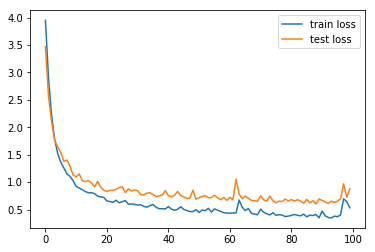

In [31]:
plt.plot(np.arange(EPOCHS), train_losses, label='train loss')
plt.plot(np.arange(EPOCHS), test_losses, label='test loss')
plt.legend()

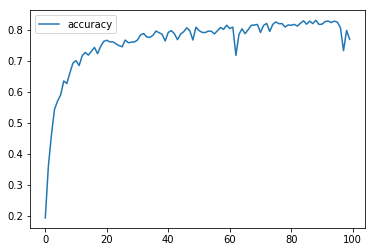

In [32]:
plt.plot(np.arange(EPOCHS), test_acc, label='accuracy')
plt.legend()